**Problem Statement :**

1.Create a ML solution for categorising bank transactions, use the sample data set which is already categorised.

2.Analyse the distribution of transaction categories

3.Examine transaction amount, merchant frequency and text patterns.

4.Identity any data issues or biases

**Expected Output : **

Train at least one classification model (XGBoost like) and compare it with another deep learning model (BERT like). T

In [5]:
import pandas as pd
import numpy as np
import os
import re
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


import nltk
from nltk.corpus import stopwords
from string import punctuation
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,recall_score,f1_score
from sklearn import metrics

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import silhouette_score

import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline


warnings.filterwarnings('ignore')

sns.set()
seed=1
os.environ["TF_USE_LEGACY_KERAS"] = "1"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [8]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [9]:
#Navigate to folder with data on drive
os.listdir()
os.chdir('drive/MyDrive/Codility')
os.listdir()

['Copy of test_transactions0.1.xls',
 'finetuned_bert',
 'Untitled0.ipynb',
 'BankTransactionClassifier.ipynb',
 'test_bert_save',
 'TestBert.ipynb',
 'test_transactions0.1.xlsx',
 'model.png',
 'finetuned_bert_1',
 'TestLLMForClassification.ipynb',
 'BankTransactionClassifier_v2.ipynb']

In [37]:
tx_data = pd.read_excel('test_transactions0.1.xlsx')

In [38]:
tx_data.head(5)

,Date,Amount,Merchant,Category,Description
0,2025-03-16,80814.70,UNICEF,Charity,Donated INR 80814.7 via UNICEF on 16-Mar-2025...
1,2025-03-16,61816.17,Bharat Petroleum,Fuel,Filled up at Bharat Petroleum on 16-Mar-2025 i...
2,2025-03-16,110825.48,HDFC ATM,Cash Withdrawal,"Withdrawn INR 110825.48 from HDFC ATM ATM, Hy..."
3,2025-03-16,87042.87,Natureâ€™s Basket,Groceries,A substantial shopping haul from Natureâ€™s Ba...
4,2025-03-16,16158.42,GenericMerchant,Miscellaneous,Paid INR 16158.42 for a variety of small misc...


# Perform EDA & Data Cleaning

In [39]:
print("Shape: ",tx_data.shape)
print("Data Types", tx_data.dtypes)

Shape:  (5000, 5)
Data Types Date           datetime64[ns]
Amount                float64
Merchant               object
Category               object
Description            object
dtype: object


In [40]:
# Check for missing and duplicate values
print("Missing values per column:")
print(tx_data.isnull().sum())


print("\n \nDuplicate data:\n",tx_data[tx_data.duplicated()])

Missing values per column:
Date           0
Amount         0
Merchant       0
Category       0
Description    0
dtype: int64

 
Duplicate data:
 Empty DataFrame
Columns: [Date, Amount, Merchant, Category, Description]
Index: []


As can be seen, there are no null values in the data set and hence no need for imputation. Also, there is no duplicate data that needs to be cleaned.

In [41]:
# Check for data with special characters
def check_special_chars(col_name, data):
  special_char_pattern = re.compile(r'[^\w\s]')
  merchants_with_special = data[data[col_name].apply(lambda x: bool(special_char_pattern.search(str(x))) if pd.notnull(x) else False)][col_name]
  print("\nData containing special characters:")
  print(merchants_with_special.unique())

# Check columns with potential for special characters
print("Checking for Merchant", check_special_chars("Merchant",tx_data))
print("Checking for Category", check_special_chars("Category",tx_data))


Data containing special characters:
['Natureâ€™s Basket' "Domino's" 'D-Mart' "Byju's" 'CafÃ© Coffee Day']
Checking for Merchant None

Data containing special characters:
[]
Checking for Category None


In [42]:
# Remove special charaters to avoid potential data issues during modeling
def clean_data_in_col(col_data):
    if pd.isnull(col_data):
        return col_data
    return re.sub(r'[^\w\s]', '', str(col_data))

tx_data['Merchant'] = tx_data['Merchant'].apply(clean_data_in_col)
print("\n'Merchant' column cleaned of special characters.")
# Print all unique merchants by count
print("\nUnique merchants by transaction count:")
print(tx_data['Merchant'].value_counts())

#Validate no special chars left
print("Checking for Merchant again ", check_special_chars("Merchant",tx_data))


'Merchant' column cleaned of special characters.

Unique merchants by transaction count:
Merchant
GenericMerchant    610
HP Petrol Pump     113
Indian Oil          99
Big Bazaar          98
GoFundMe            91
                  ... 
Jio                 45
BWSSB               45
Tata CLiQ           43
DishTV              43
ACT Fibernet        42
Name: count, Length: 66, dtype: int64

Data containing special characters:
[]
Checking for Merchant again  None


In [43]:
#Check unique values for Merchant and Category
# Except Date & Description
columns=['Merchant', 'Category']
for col in columns:
    print('\nUnique values for ',col)
    unique_val = np.sort(tx_data[col].unique())
    print(unique_val)
    print('No. of unique values: ',len(unique_val))


Unique values for  Merchant
['1mg' 'ACT Fibernet' 'Accenture' 'Airtel' 'Ajio' 'Amazon'
 'Apollo Hospitals' 'Axis Bank ATM' 'BESCOM' 'BWSSB' 'Bajaj Allianz'
 'Barbeque Nation' 'Bharat Petroleum' 'Big Bazaar' 'BookMyShow' 'Byjus'
 'CRY' 'CafÃ Coffee Day' 'Coursera' 'DMart' 'DishTV' 'Dominos' 'Flipkart'
 'Fortis Hospital' 'GenericMerchant' 'GiveIndia' 'GoFundMe' 'Groww'
 'HDFC ATM' 'HDFC Life' 'HP Petrol Pump' 'Hotstar' 'IBM' 'ICICI ATM'
 'ICICI Direct' 'ICICI Prudential' 'IRCTC' 'IndiGo' 'Indian Oil' 'Infosys'
 'Jio' 'LIC' 'MakeMyTrip' 'MedPlus' 'Myntra' 'Natureâs Basket' 'Netflix'
 'Ola' 'Paytm Money' 'Practo' 'Reliance Fresh' 'SBI ATM' 'SBI Life'
 'SonyLIV' 'Spotify' 'Swiggy' 'TCS' 'Tata CLiQ' 'UNICEF' 'Uber' 'Udemy'
 'UpGrad' 'Upstox' 'Wipro' 'Zerodha' 'Zomato']
No. of unique values:  66

Unique values for  Category
['Cash Withdrawal' 'Charity' 'Dining' 'Education' 'Entertainment' 'Fuel'
 'Groceries' 'Healthcare' 'Insurance' 'Investment' 'Miscellaneous'
 'Salary' 'Shopping' 'Taxes' '

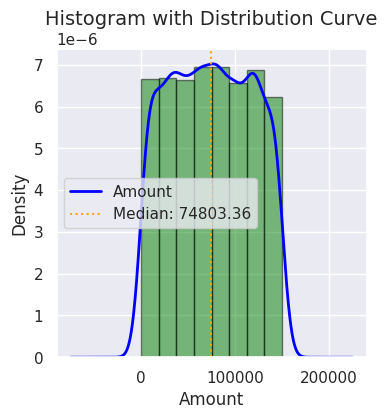

In [71]:
# Check distribution of amount
plt.figure(figsize=(4, 4))
plt.hist(tx_data['Amount'], bins=8, density=True, alpha=0.5, color='green', edgecolor='black')

# Add density curve
tx_data['Amount'].plot(kind='kde', linewidth=2, color='blue')

# Add median line
median_val = tx_data['Amount'].median()
plt.axvline(median_val, color='orange', linestyle=':', label=f'Median: {median_val:.2f}')

plt.title('Histogram with Distribution Curve', fontsize=14)
plt.xlabel('Amount', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.show()


Amount has an almost normal distribution

In [44]:
# Check Distribution of categorical features
def check_dist_categorical(data, col_name):
  counts = data[col_name].value_counts()
  percentages = data[col_name].value_counts(normalize=True) * 100

  # Combine into one DataFrame
  summary_df = pd.DataFrame({
      'Count': counts,
      'Percentage': percentages.round(2)
  })

  print(summary_df)

  plt.figure(figsize=(30,3))

  plt.subplot(1, 2 , 1)
  sns.countplot(x=col_name, data=data, order = data[col_name].
                value_counts().index, palette="YlGnBu", hue=col_name, legend=False)
  plt.xticks(rotation=90)
  plt.show()

                 Count  Percentage
Merchant                          
GenericMerchant    610       12.20
HP Petrol Pump     113        2.26
Indian Oil          99        1.98
Big Bazaar          98        1.96
GoFundMe            91        1.82
...                ...         ...
Jio                 45        0.90
BWSSB               45        0.90
Tata CLiQ           43        0.86
DishTV              43        0.86
ACT Fibernet        42        0.84

[66 rows x 2 columns]


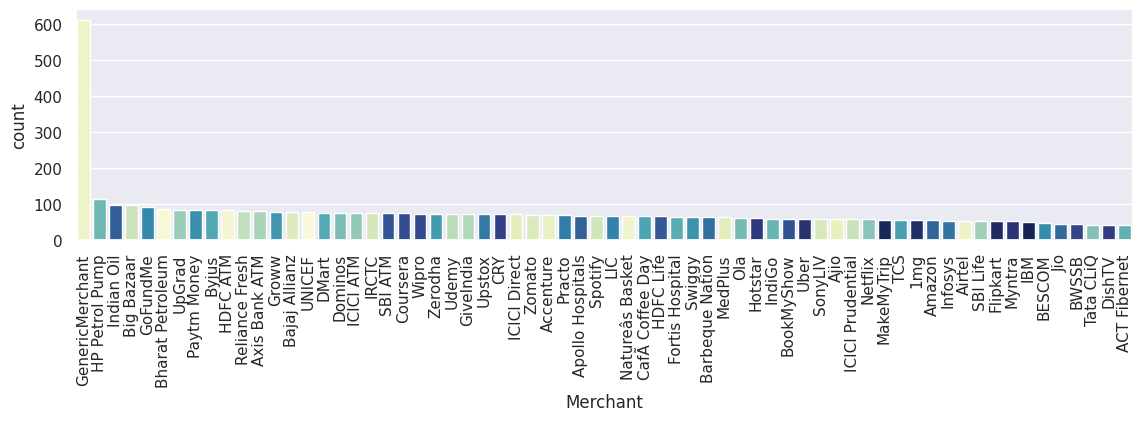

In [45]:
check_dist_categorical(tx_data,"Merchant")

                 Count  Percentage
Category                          
Investment         381        7.62
Dining             342        6.84
Insurance          323        6.46
Groceries          322        6.44
Healthcare         321        6.42
Miscellaneous      317        6.34
Education          317        6.34
Cash Withdrawal    315        6.30
Charity            313        6.26
Travel             313        6.26
Entertainment      305        6.10
Salary             302        6.04
Fuel               298        5.96
Taxes              293        5.86
Utilities          278        5.56
Shopping           260        5.20


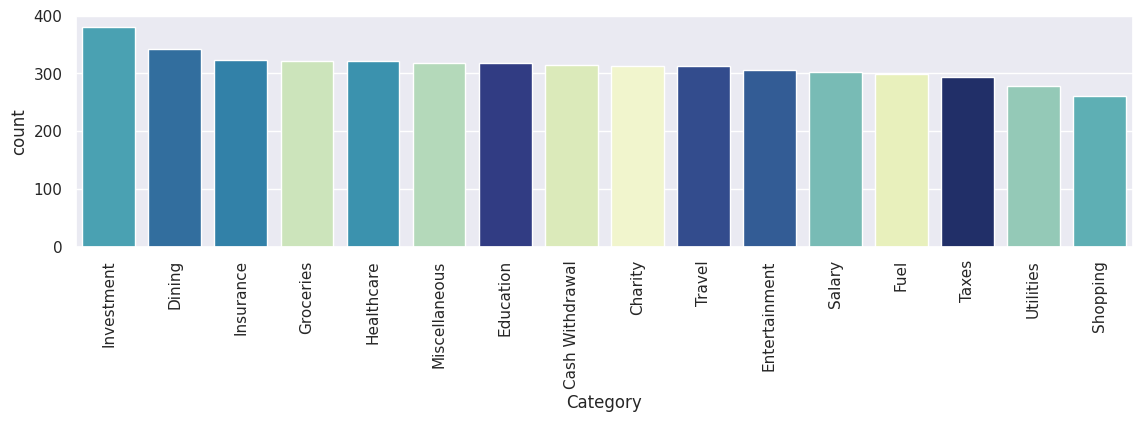

In [46]:
check_dist_categorical(tx_data,"Category")

               Count  Percentage
Category                        
Miscellaneous    317       51.97
Taxes            293       48.03


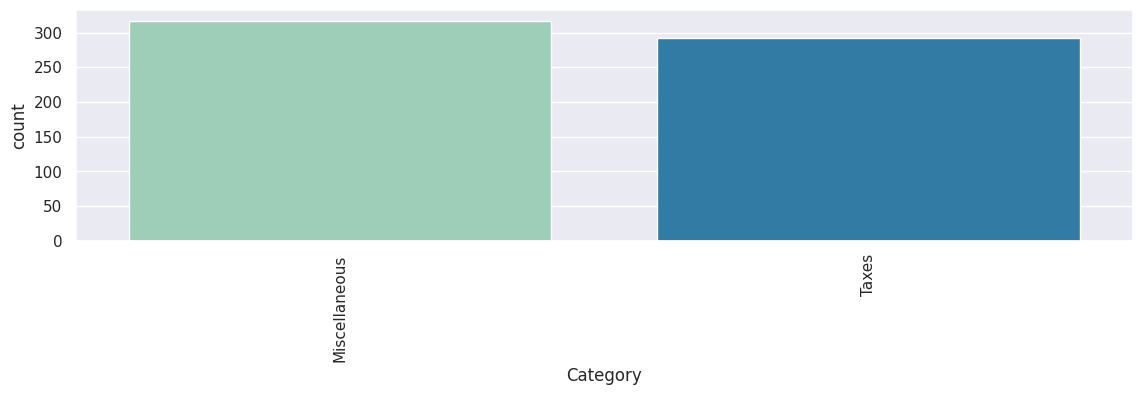

In [47]:
# Check distribution of categories for Generic Merchant as it appears in majority
check_dist_categorical(tx_data[tx_data["Merchant"] == "GenericMerchant"],"Category")

Based on the distributions seen above, below are the observations:
1. Merchant:
- There is a higher percentage of "Generic Merchant" (12.1%) entries in the dataset. So the dataset is biased towards "Generic Merchant".
- However, categories for this Merchant type converge into only 2 types i.e. Miscellaneous and Taxes and hence, if this used in conjunction with Description, it can help eliminate this bias

2. Category:
- The dataset is mostly balanced as the no. of records per Category is more or less similar
- This is the target variable and this dataset can be concluded to be a balanced dataset with respect to the target variable.

# Check correlation between the features

In [48]:
# Add new features for the date to validate if there is any correlation with the categorization
tx_data['date'] = tx_data['Date'].dt.day
tx_data['year'] = tx_data['Date'].dt.year
tx_data['month'] = tx_data['Date'].dt.month_name()
tx_data['day'] = tx_data['Date'].dt.day_name()

In [49]:
tx_data.head(2)

,Date,Amount,Merchant,Category,Description,date,year,month,day
0,2025-03-16,80814.70,UNICEF,Charity,Donated INR 80814.7 via UNICEF on 16-Mar-2025...,16,2025,March,Sunday
1,2025-03-16,61816.17,Bharat Petroleum,Fuel,Filled up at Bharat Petroleum on 16-Mar-2025 i...,16,2025,March,Sunday


In [50]:
# Find correlation between categorical data
def cramers_v_matrix(df, categorical_columns):
    def cramers_v(x, y):
        confusion_matrix = pd.crosstab(x, y)
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

    matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)
    for col1 in categorical_columns:
        for col2 in categorical_columns:
            matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])
    return matrix.astype(float)


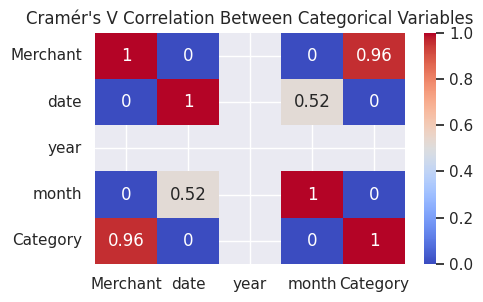

In [51]:
categorical_columns = ['Merchant', 'date', 'year','month','Category']
cramer_matrix = cramers_v_matrix(tx_data, categorical_columns)

plt.figure(figsize=(5, 3))
sns.heatmap(cramer_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Cramér's V Correlation Between Categorical Variables")
plt.show()

It can be seen from the above heat map that Category has high correlation with Merchant, but no correlation with the date. So we can drop the date column as it does not contribute to predication of Category.

In [52]:
tx_data.drop(columns=["Date","date","year","month","day"], inplace=True)
tx_data.head(2)

,Amount,Merchant,Category,Description
0,80814.70,UNICEF,Charity,Donated INR 80814.7 via UNICEF on 16-Mar-2025...
1,61816.17,Bharat Petroleum,Fuel,Filled up at Bharat Petroleum on 16-Mar-2025 i...


In [53]:
# Find correlation between amount and category
from sklearn.feature_selection import mutual_info_classif

# Encode categorical column
X = tx_data[['Amount']]
y = tx_data['Category']

mi = mutual_info_classif(X, y, discrete_features=False)
print(dict(zip(X.columns, mi)))

{'Amount': np.float64(0.012572544518496098)}


The correlation between Amount and Category is very weak.
Checking below for existence of any patterns for Amount by Category.


Generating plot for mean amount per category


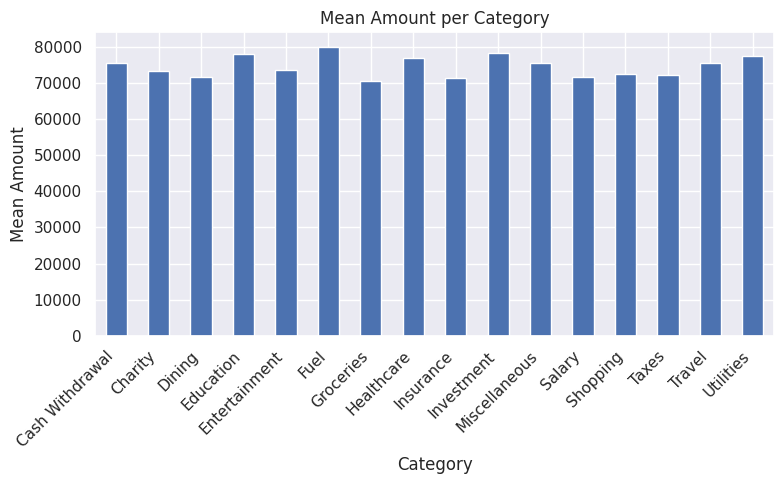

In [54]:
print("\nGenerating plot for mean amount per category")
mean_amount_per_category = tx_data.groupby('Category')['Amount'].mean()
plt.figure(figsize=(8, 5))
mean_amount_per_category.plot(kind='bar')
plt.title('Mean Amount per Category')
plt.xlabel('Category')
plt.ylabel('Mean Amount')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The correlation between Amount and Category is weak and the above plot also shows that the mean amount spent for different categories is more or less the same. So the Amount may is not a strong feature to predict the category and it can also be dropped if needed. (Retaining the Amount for this experiment).

# Process Textual Data

In [55]:
# List of stop words including punctuation
stop = set(stopwords.words('english'))
punctuation = list(punctuation)
stop.update(punctuation)

#Removing the noisy text
def get_clean_text(text):
    text = text.lower()
    text = re.sub(r"\-", " ", text)
    text=re.sub('\.', ' ', text)
    text = re.sub("\d+", "", text)
    words=nltk.word_tokenize(text)
    words=[word for word in words if not word in set(stop)]
    text = " ".join(words)
    return text

#Apply function
tx_data['Cleaned_Description']=tx_data['Description'].apply(get_clean_text)
tx_data.head(2)

,Amount,Merchant,Category,Description,Cleaned_Description
0,80814.70,UNICEF,Charity,Donated INR 80814.7 via UNICEF on 16-Mar-2025...,donated inr via unicef mar supporting medical ...
1,61816.17,Bharat Petroleum,Fuel,Filled up at Bharat Petroleum on 16-Mar-2025 i...,filled bharat petroleum mar noida spent inr li...


# XGBoost
Training an XGBoost Classifier which will take both text as well as structured inputs.
Inputs:
- Description (cleaned and vectorized using TF-iDF)
- Merchant (Encoded)
- Amount (Scaled)

Output:
Category (Label Encoded)

In [56]:
tfidf = TfidfVectorizer(max_features=100)
X_text = tfidf.fit_transform(tx_data['Cleaned_Description'])

In [57]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

X_struct = tx_data[['Amount', 'Merchant']]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['Amount']),
    ('cat', OneHotEncoder(), ['Merchant'])
])

X_struct_processed = preprocessor.fit_transform(X_struct)

In [58]:
#Label Encode the target column
cat_label_enc = LabelEncoder()
tx_data["Category_enc"] = cat_label_enc.fit_transform(tx_data["Category"])

In [59]:
#Combine Text annd structured inputs and split the dataset into training and test data
from scipy.sparse import hstack

X_combined = hstack([X_text, X_struct_processed])
y = tx_data['Category_enc'].values
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=seed, stratify=tx_data['Category_enc'])

In [60]:
#Train XGB Classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9993333333333333


As can be seen above XGBoost performs very well on the given data set and we see a test accuracy of 99.9%.

# Unsupervised Learning - K-Means Clustering
Trying to identify categorical clusters based on the Amount and Merchant using K-means Clustering.

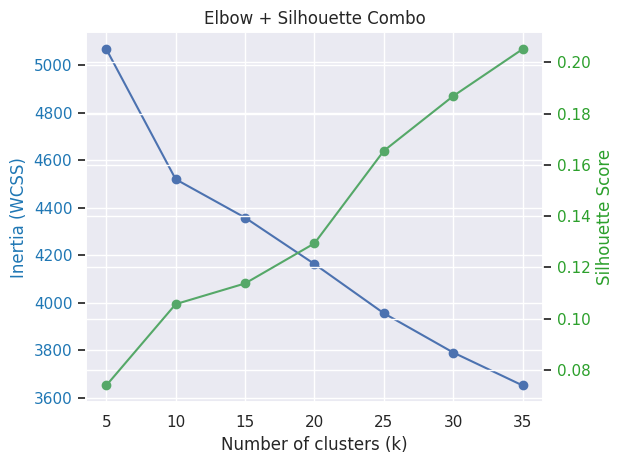

In [61]:
inertias = []
silhouettes = []
k_values = range(5, 40, 5)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=seed).fit(X_struct_processed)
    labels = kmeans.labels_

    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_struct_processed, labels))

# Plot elbow (inertia) + silhouette together
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia (WCSS)', color=color)
ax1.plot(k_values, inertias, 'bo-', label='Inertia')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(k_values, silhouettes, 'go-', label='Silhouette')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Elbow + Silhouette Combo')
fig.tight_layout()
plt.show()


As can be seen above, the elbow appears in the inertia curve at n_clusters = 10 and the Silhouette score is still decent.
So we will choose n_clusters = 10.

In [62]:
kmeans_data = pd.DataFrame(tx_data)
kmeans = KMeans(n_clusters=10, random_state=seed)
kmeans_data['Cluster'] = kmeans.fit_predict(X_struct_processed)

In [63]:
kmeans_data.head(5)

,Amount,Merchant,Category,Description,Cleaned_Description,Category_enc,Cluster
0,80814.70,UNICEF,Charity,Donated INR 80814.7 via UNICEF on 16-Mar-2025...,donated inr via unicef mar supporting medical ...,1,9
1,61816.17,Bharat Petroleum,Fuel,Filled up at Bharat Petroleum on 16-Mar-2025 i...,filled bharat petroleum mar noida spent inr li...,5,5
2,110825.48,HDFC ATM,Cash Withdrawal,"Withdrawn INR 110825.48 from HDFC ATM ATM, Hy...",withdrawn inr hdfc atm atm hyderabad mar locat...,0,1
3,87042.87,Natureâs Basket,Groceries,A substantial shopping haul from Natureâ€™s Ba...,substantial shopping haul natureâ€™s basket de...,6,6
4,16158.42,GenericMerchant,Miscellaneous,Paid INR 16158.42 for a variety of small misc...,paid inr variety small miscellaneous purchases...,10,8


K-Means Clustering is usually used to identify patterns in the data. These clusters can firther be used to compare and analyse the Categories.

# Supervised Deep Learning
Fine-tune BERT model to predict the category. We will use structured inputs as well as text for this

Note: Due to exhaustion of GPU, the fine-tuning of Bert was crashing. Below are the steps to achieve a fine-tuned Bert model which will take structured as well as textual input and predict the category.

Inputs:
- Merchant (Categorical)
- Amount (Numerical)
- Description (Text)

Output:
- Category

In [65]:
df = pd.DataFrame(tx_data)

# Encode categorical features
source_encoder = LabelEncoder()
df['Merchant_enc'] = source_encoder.fit_transform(df['Merchant'])

# Normalize numerical features
df['Amount_norm'] = (df['Amount'] - df['Amount'].mean()) / df['Amount'].std()

# Split data
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=seed)

In [66]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize text inputs
def tokenize(texts):
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors="tf"
    )


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [67]:
train_encodings = tokenize(train_df['Description'])
val_encodings = tokenize(val_df['Description'])

# Model parameters
num_classes = len(np.unique(df['Category']))
bert_model_name = 'bert-base-uncased'

In [47]:
import tf_keras as k3

# Create multi-input model
def create_multi_input_bert_model():
    # Text input
    text_input_ids = k3.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
    text_attention_mask = k3.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

    # Load pre-trained BERT
    bert = TFBertModel.from_pretrained(bert_model_name)
    bert_output = bert({'input_ids': text_input_ids, 'attention_mask': text_attention_mask})[1]

    # Prepare structured inputs
    categorical_input = k3.layers.Input(shape=(1,), dtype=tf.int32, name='merchant_input')
    numerical_input = k3.layers.Input(shape=(1,), dtype=tf.float32, name='amount_input')

    # Embed categorical feature
    embedded_cat = k3.layers.Embedding(
        input_dim=len(source_encoder.classes_),
        output_dim=4,
        input_length=1
    )(categorical_input)
    embedded_cat = k3.layers.Flatten()(embedded_cat)

    # Concatenate structured as well as text inputs
    concatenated = k3.layers.Concatenate()([bert_output, embedded_cat, numerical_input])

    # Add dense layers
    x = k3.layers.Dense(64, activation='relu')(concatenated)
    x = k3.layers.Dropout(0.2)(x)
    output = k3.layers.Dense(num_classes, activation='softmax')(x)

    # Create model
    model = k3.Model(
        inputs=[text_input_ids, text_attention_mask, categorical_input, numerical_input],
        outputs=output
    )

    return model

model = create_multi_input_bert_model()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

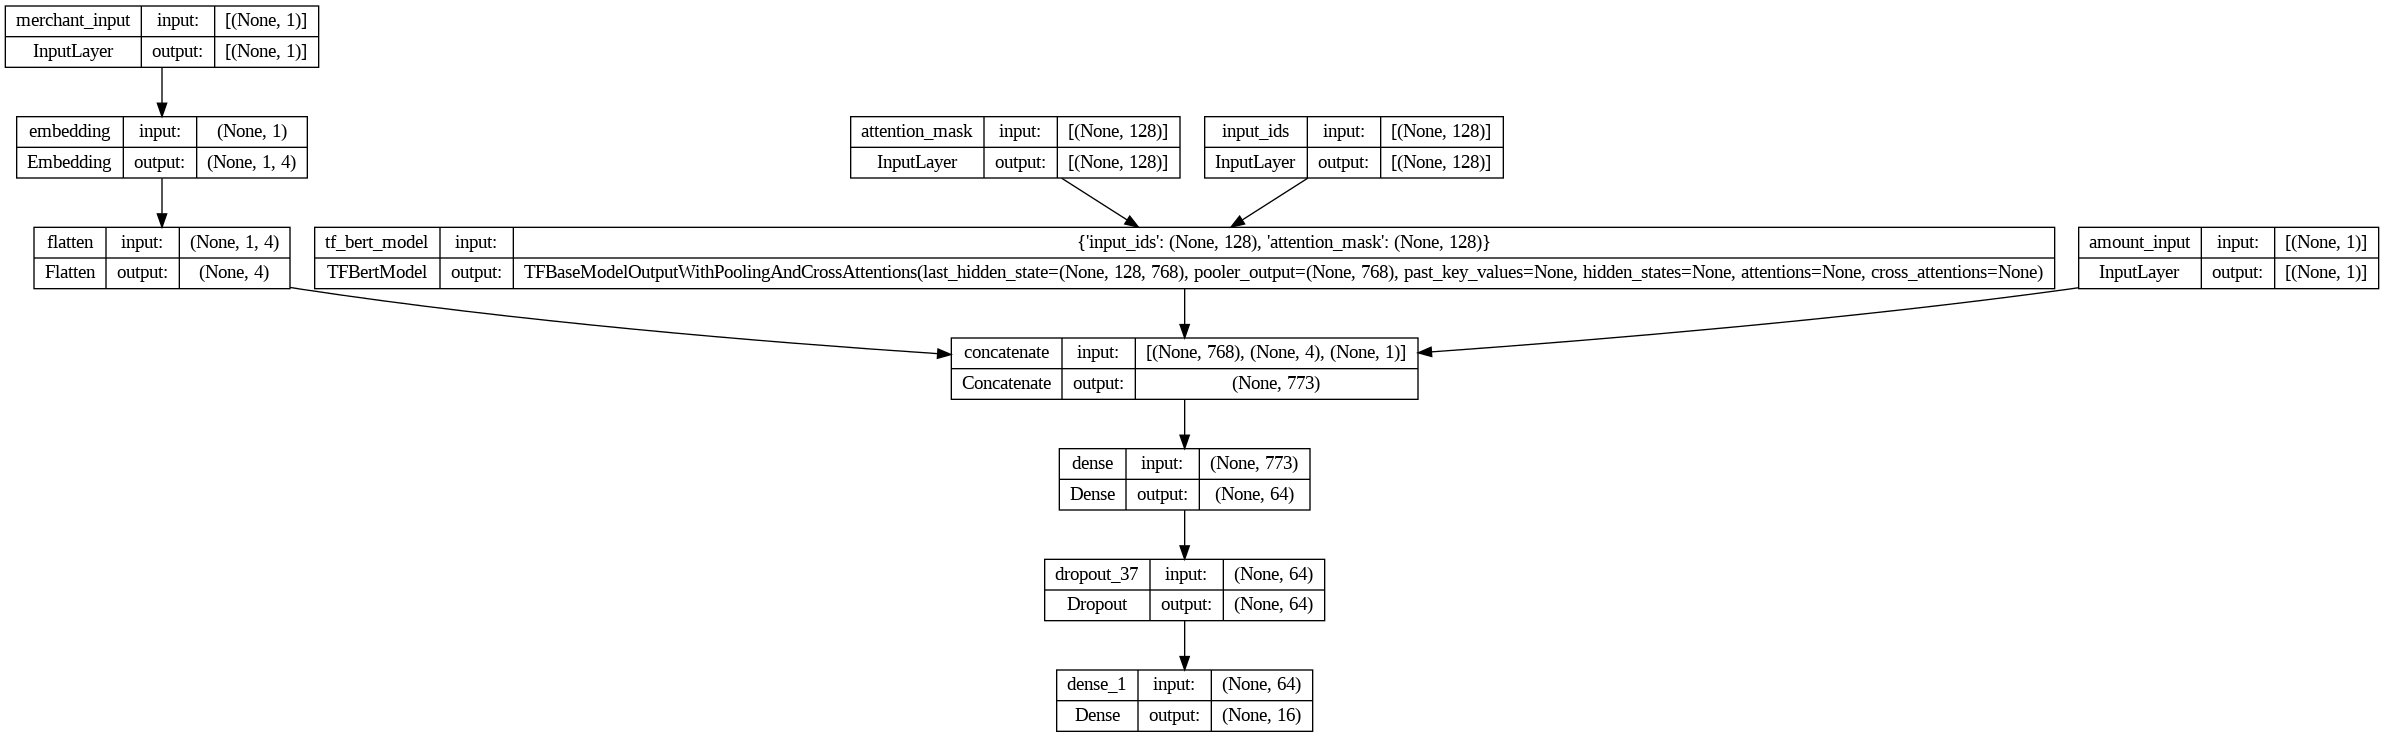

In [49]:
k3.utils.plot_model(model, show_shapes=True)

In [50]:
# Compile the model
model.compile(
    optimizer=k3.optimizers.Adam(learning_rate=2e-5),
    loss=k3.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Prepare input data
train_inputs = {
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'merchant_input': train_df['Merchant_enc'].values,
    'amount_input': train_df['Amount_norm'].values
}

val_inputs = {
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'merchant_input': val_df['Merchant_enc'].values,
    'amount_input': val_df['Amount_norm'].values
}

# Train the model
history = model.fit(
    train_inputs,
    train_df['Category_enc'].values,
    validation_data=(val_inputs, val_df['Category_enc'].values),
    batch_size=8,
    epochs=1 #Only running 1 epoch due to GPU unavailability
)

save_directory = "./finetuned_bert_1"
model.save(save_directory)

500/500 [==============================] - 6676s 13s/step - loss: 0.5626 - accuracy: 0.8830 - val_loss: 0.0185 - val_accuracy: 1.0000


In [54]:
history.history

{'loss': [0.5625698566436768],
 'accuracy': [0.8830000162124634],
 'val_loss': [0.018466288223862648],
 'val_accuracy': [1.0]}

In [55]:
print("Results for BERT")
print("Size of validation data:" , len(val_df['Category_enc']))
print(history.history)

Results for BERT
Size of validation data: 1000
{'loss': [0.5625698566436768], 'accuracy': [0.8830000162124634], 'val_loss': [0.018466288223862648], 'val_accuracy': [1.0]}


**A validation Accuracy of 1 has been achieved for the fine-tuned BERT.**

# Additional Experiment: Using Generative
Selecting 100 records from the test set to check accuracy on using ChatGPT

In [11]:
tx_data = pd.read_excel('test_transactions0.1.xlsx')

In [12]:
train_df, val_df = train_test_split(tx_data, test_size=0.2, random_state=42)

In [30]:
df_sampled, _ = train_test_split(
    val_df,
    stratify=val_df['Category'],
    train_size=20,
    random_state=seed
)

In [20]:
df_sampled.head(2)

,Date,Amount,Merchant,Category,Description
3814,2025-04-30,110726.46,DishTV,Utilities,Electricity bill payment to DishTV on 30-Apr-2...
4692,2025-05-11,69392.96,Flipkart,Shopping,Discounted apparel shopping via Flipkart on 11...


In [ ]:
#!pip install langchain langchain-community
#!pip install openai

In [32]:
import os
from langchain_community.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
import time

In [23]:
from google.colab import userdata
openai_api_key = userdata.get('OPENAI_API_KEY')

# Initialize OpenAI Chat model with LangChain
chat = ChatOpenAI(api_key=openai_api_key, model="gpt-3.5-turbo", temperature=0.1)

In [24]:
prompt = """Below are some details of a bank transaction. Your task is to classify the transaction into one of the
following 'categories':
categories:
- Charity
- Fuel
- Cash Withdrawal
- Groceries
- Miscellaneous
- Utilities
- Salary
- Shopping
- Investment
- Healthcare
- Insurance
- Dining
- Entertainment
- Travel
- Education
- Taxes
You will be provided with a 'Description' of the transaction below and a 'Merchant_Name'
which denotes the party involved in the transaction within triple backticks below.
Reply only with the output Category
Do not add any additional data
```
Description: {desc}
Merchant_Name: {merch}
```
"""

In [25]:
# Initialize LangChain with the prompt template and Chat model
prompt = PromptTemplate(input_variables=["desc","merch"], template=prompt)
llm_chain = LLMChain(prompt=prompt, llm=chat)

In [33]:
df_sampled['pred_category'] = ''
for idx, row in df_sampled.iterrows():
  desc= row.Description
  merch=row.Merchant
  # Generate the response
  response = llm_chain.run({
      "desc": desc,
      "merch": merch
  })
  df_sampled.at[idx, 'pred_category'] = response.strip()
  print("\n desc: ",desc)
  print("predicted category: ",response.strip())

  # Sleep to avoid rate limit errors
  time.sleep(1)

In [35]:
df_sampled.head(5)

,Date,Amount,Merchant,Category,Description,pred_category
2526,2025-04-14,79693.48,Wipro,Salary,Employee wages of INR 79693.48 paid by Wipro ...,Salary
3098,2025-04-21,25763.78,Axis Bank ATM,Cash Withdrawal,Cash withdrawal of INR 25763.78 from Axis Ban...,Cash Withdrawal
4692,2025-05-11,69392.96,Flipkart,Shopping,Discounted apparel shopping via Flipkart on 11...,Shopping
3331,2025-04-24,62567.85,SonyLIV,Entertainment,Booked movie tickets for INR 62567.85 through...,Entertainment
4246,2025-05-05,97598.64,IRCTC,Travel,"Traveled by train with IRCTC on 05-May-2025, f...",Travel


In [36]:
llm_acc = accuracy_score(df_sampled["Category"], df_sampled["pred_category"])
print("LLM Accuracy: ",llm_acc)

LLM Accuracy:  1.0


# Conclusion
The dataset provided is very clean with respect to balance, missing/duplicate values etc.
This has assisted all the models that have been experimented to show good results with minimal data preprocessing, feature engineering or additional fine-tuning.
Below are the accuracies of all models:
1. XGBoost: 99.9%
2. BERT (Fine-tuned):100%
3. Generative AI based solution (very small dataset): 100%